Trained on Kaggle with dataset:
https://www.kaggle.com/datasets/arnaud58/landscape-pictures

## Preprocessing and Training

In [ ]:
!pip install tensorflow-io
!pip install tensorflow-datasets

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_io as tfio

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

In [ ]:
BUFFER_SIZE = 600
BATCH_SIZE = 1
IMG_WIDTH = 512
IMG_HEIGHT = 512

In [ ]:
def load(image_file):
    image = tf.io.read_file(image_file)
    real_image = tf.io.decode_jpeg(image,channels=3)
#     input_image = tf.io.decode_jpeg(image,channels=1)

    input_image = tfio.experimental.color.rgb_to_grayscale(real_image)
    input_image = tf.image.grayscale_to_rgb(input_image)

    # Convert both images to float32 tensors
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.BILINEAR)
    real_image = tf.image.resize(real_image, [height, width], method=tf.image.ResizeMethod.BILINEAR)
    return input_image, real_image

# Normalizing the images to [0, 1]
def normalize(input_image, real_image):
    input_image = input_image / 255.0
    real_image = real_image / 255.0
    return input_image, real_image

In [ ]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

In [ ]:
train_dataset = tf.data.Dataset.list_files(str('/kaggle/input/landscape-pictures/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
train_dataset

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [ ]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [ ]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[512, 512, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
        ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
        ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
LAMBDA = 100

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[512, 512, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[512, 512, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [ ]:
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

In [ ]:
# Initialize strategy FIRST
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    generator = Generator()
    discriminator = Discriminator()
    generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = '/kaggle/working/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
log_dir="/kaggle/working/logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
# @tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([target, target], training=False)
        disc_generated_output = discriminator([target, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
#     return gen_total_loss,disc_loss
    # with summary_writer.as_default():
    #   tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    #   tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    #   tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    #   tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [ ]:
@tf.function
def distributed_train_step(input_image, target, step):
  strategy.run(train_step, args=(input_image, target, step))
#   return strategy.reduce(tf.distribute.ReduceOp.NONE, gen_loss,disc_loss,
#                          axis=None)

In [ ]:
def fit(train_ds, steps):
    example_input, example_target = next(iter(train_ds.take(1)))
    start = time.time()
    latest_checkpoint = None  

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            display.clear_output(wait=True)
            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')
            start = time.time()
            print(f"Step: {step//1000}k")

        distributed_train_step(input_image, target, step)

        if (step+1) % 10 == 0:
            print('.', end='', flush=True)

        if (step + 1) % 1000 == 0:
            # Save new checkpoint and get its path
            latest_checkpoint = checkpoint.save(file_prefix=checkpoint_prefix)
            
            # Delete all except current and previous 2 checkpoints
            checkpoints = sorted(tf.io.gfile.glob(f"{checkpoint_prefix}*"),
                               key=lambda x: int(x.split('-')[-1].split('.')[0]))
            
            for old_checkpoint in checkpoints[:-3]:
                tf.io.gfile.rmtree(os.path.dirname(old_checkpoint)) if tf.io.gfile.isdir(old_checkpoint) \
                    else tf.io.gfile.remove(old_checkpoint)
                print(f"Deleted: {old_checkpoint}")

In [ ]:
fit(train_dataset, steps=14000)

In [ ]:
generator.save('/kaggle/working/landColorGenV3.keras')

## Testing

Preprocessing input image...
Performing inference...
1/1 [==============================] - 0s 453ms/step
Saving output image...
Colorized image saved at: colorized1.jpg


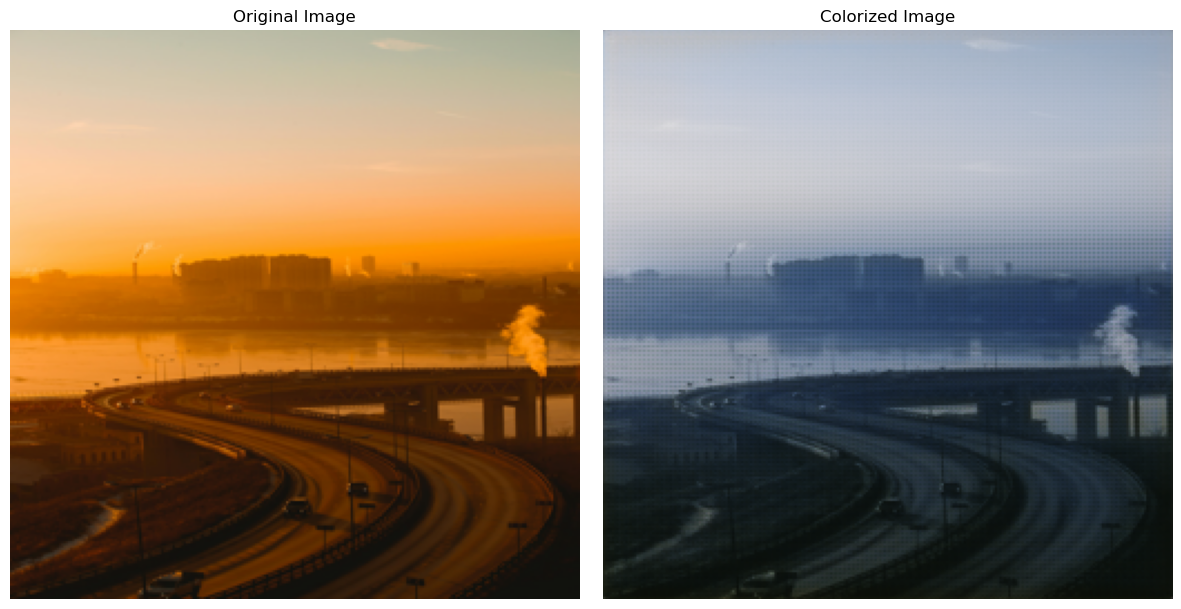

Preprocessing input image...
Performing inference...
1/1 [==============================] - 0s 114ms/step
Saving output image...
Colorized image saved at: colorized2.jpg


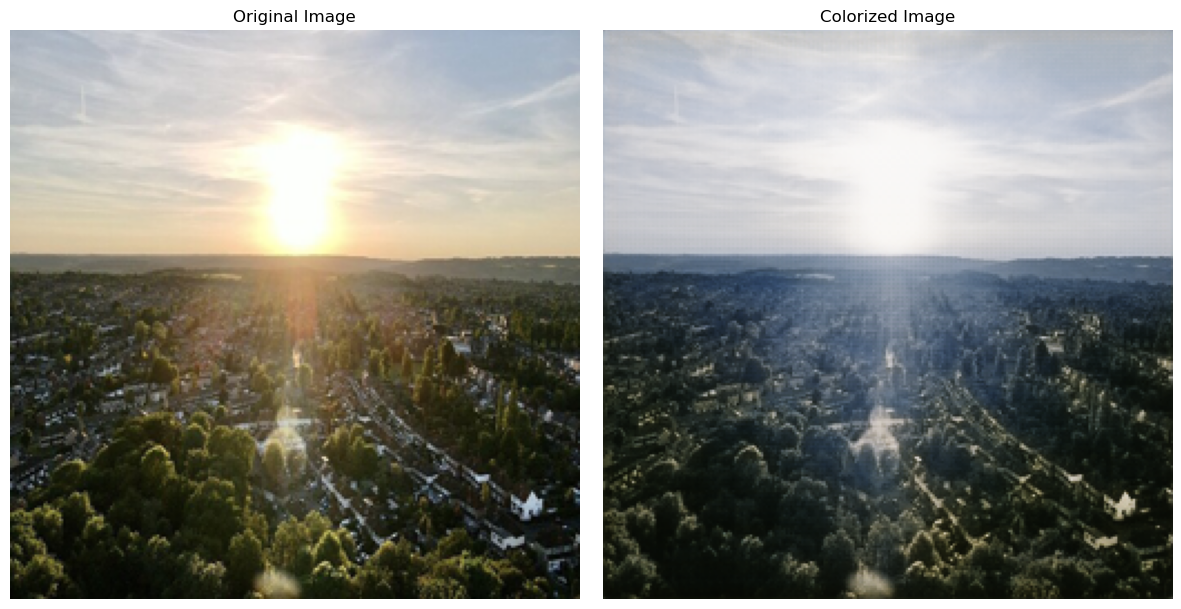

In [32]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from PIL import Image
import os 

def preprocess_image(image_path, img_width=256, img_height=256):
    # Load image and convert to RGB
    original_image = Image.open(image_path).convert("RGB")
    
    # Resize original for display to match output size
    resized_original = original_image.resize((img_width, img_height))
    
    # Normalize pixel values to [-1, 1]
    image_array = (np.array(resized_original).astype(np.float32) / 127.5) - 1
    
    # Add batch dimension for model inference
    return np.expand_dims(image_array, axis=0), np.array(resized_original)

def save_colorized_image(prediction, output_path):
    # Rescale pixel values from [-1, 1] to [0, 255]
    rescaled_image = ((prediction * 0.5 + 0.5) * 255).astype(np.uint8)
    
    # Convert array to PIL Image and save
    Image.fromarray(rescaled_image).save(output_path)
    print(f"Colorized image saved at: {output_path}")
    
    return rescaled_image

def display_comparison(original, colorized):
    # Create a figure with two subplots side by side
    plt.figure(figsize=(12, 6))
    
    # Display resized original image
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis('off')
    
    # Display colorized image
    plt.subplot(1, 2, 2)
    plt.imshow(colorized)
    plt.title("Colorized Image")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def generate_and_save_single_image(model, input_image_path, output_image_path):
    # Preprocess the input image
    print("Preprocessing input image...")
    processed_image, resized_original = preprocess_image(input_image_path)
    
    # Perform inference
    print("Performing inference...")
    prediction = model.predict(processed_image)[0]  # Remove batch dimension
    
    # Save the colorized output image
    print("Saving output image...")
    colorized_image = save_colorized_image(prediction, output_image_path)
    
    # Display both the resized original and colorized images
    display_comparison(resized_original, colorized_image)

generator = tf.keras.models.load_model('landColorGenV2.keras')

INPUT_IMAGE_PATH = "Image1.jpg" 
OUTPUT_IMAGE_PATH = "colorized1.jpg" 

generate_and_save_single_image(generator, INPUT_IMAGE_PATH, OUTPUT_IMAGE_PATH)

INPUT_IMAGE_PATH = "sunglare3.jpeg" 
OUTPUT_IMAGE_PATH = "colorized2.jpg" 

generate_and_save_single_image(generator, INPUT_IMAGE_PATH, OUTPUT_IMAGE_PATH)

## Glare Removal

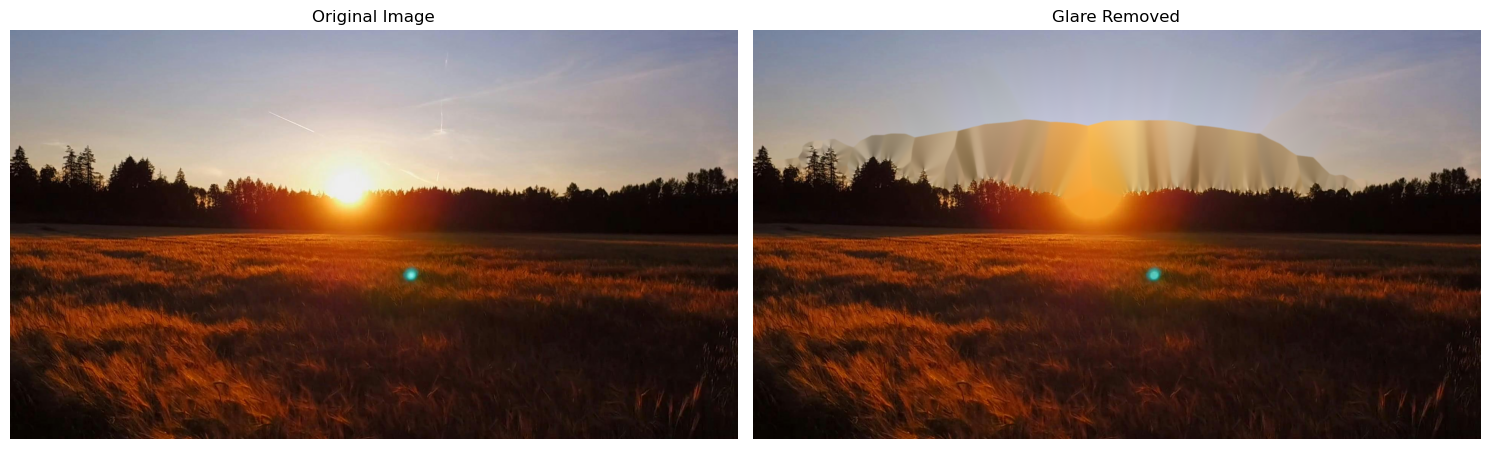

True

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to display images in the notebook
def display_images(images, titles, rows=1, figsize=(15, 10)):
    fig, axes = plt.subplots(rows, len(images)//rows, figsize=figsize)
    axes = axes.flatten() if len(images) > 1 else [axes]
    
    for img, title, ax in zip(images, titles, axes):
        if len(img.shape) == 3:  # Color image
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:  # Grayscale image
            ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Function to remove glare from an image
def remove_glare(image_path, threshold=170, inpaint_radius=3):
    # Load the image
    img = cv2.imread(image_path)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Create a binary mask for areas exceeding the threshold (glare)
    _, binary_mask = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    
    # Optional: Apply morphological operations to clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    
    # Apply inpainting to remove glare
    result = cv2.inpaint(img, binary_mask, inpaint_radius, cv2.INPAINT_TELEA)
    
    return img, gray, binary_mask, result

# Path to your image with glare
image_path = 'sunglare4.jpeg'  # Replace with your image path

# Remove glare (adjust threshold as needed for your specific image)
original, gray, mask, result = remove_glare(image_path, threshold=170)

# Display the results
display_images(
    [original, result],
    ['Original Image', 'Glare Removed'],
    rows=1
)

# Save the result if needed
cv2.imwrite('glare_removed.jpg', result)